## Compare the counts in both the chrM and the variant regions
### Heatmaps for them. Also do AFs correlate with variants

In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
NUM_DONORS=2
prob_threshold=0.8
INDIR = "./"
config_f = "parameters/2020_11_18.yaml"
OUTDIR='./results/'


In [3]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [4]:
# if not os.path.exists(OUTDIR):
#     os.mkdir(OUTDIR)

#os.chdir(INDIR)

In [5]:
import os
from itertools import product
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join, dirname, basename
import numpy as np

In [6]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

In [7]:
import glob
from src.utils.parse_config import read_config_file
config = read_config_file(config_f)
config

{'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/2020_11_18_Croker/MTblacklist',
 'variants_f': '/data2/mito_lineage/data/external/cellSNP_variants/processed/liftOver_chr_full_genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf',
 'genome_size': '/data/isshamie/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.chrom.size',
 'use_mt_bam': True,
 'mttrace_dir': '/data2/mito_lineage/data/processed/mttrace/2020_11_18/',
 'samples': ['PBMC_J', 'PBMC_P'],
 'pseudo_multiplex': {'num_cells': 2000, 'is_proportional': False},
 'mt': {'minMAF': [0.01, 0.1], 'minCOUNT': [10, 20, 200]},
 'pre_variant': {'minMAF': [0.1, 0.2, 0.4], 'minCOUNT': [20, 200]}}

## Loading cellSNP pileup data

In [8]:
def load_mtx_df(in_f, skip_first=True, give_header=False):
    df = pd.read_csv(in_f, comment="%", header=None, sep="\t")
    df.columns = ["Variant", "Cell", "integer"]

    if skip_first:
        head = df.iloc[0]
        df = df.iloc[1:] # Seems to be summary values
    if give_header:
        return df,head
    return df

def load_pileup(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df(curr_dp_f)
    ad = load_mtx_df(curr_ad_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df(curr_oth_f)
        return dp, ad, oth, vcf
    return dp, ad, vcf

def load_mtx_df_full(in_f, vcf_f=None):
    df = pd.DataFrame(mmread(in_f).tocsc().todense())
    df.index.name = "Variant"
    df.columns.name = "Cell"
    if vcf_f is None:
        return df
    vcf = pd.read_csv(vcf_f, sep='\t', skiprows=1)
    print(f" {in_f} shape {df.shape}")
    df = pd.merge(df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    return df

def load_pileup_full(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    curr_barcode_f = join(indir, "cellSNP.samples.tsv")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df_full(curr_dp_f, vcf_f)
    ad = load_mtx_df_full(curr_ad_f, vcf_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    barcode = pd.read_csv(curr_barcode_f, header=None)[0].values
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df_full(curr_oth_f, load_mtx_df_full)
        return dp, ad, oth, vcf
    return dp, ad, vcf, barcode

### MT

In [9]:
mt_counts = pd.DataFrame(product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
all_barcodes={}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in mt_counts.iterrows():
    curr_dir = f"data/chrM/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf, barcode = load_pileup_full(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
    all_barcodes[ind] = barcode

data/chrM/PBMC_J_cellSNP_minC10_minAF0.01/
 data/chrM/PBMC_J_cellSNP_minC10_minAF0.01/cellSNP.tag.DP.mtx shape (81, 743)
 data/chrM/PBMC_J_cellSNP_minC10_minAF0.01/cellSNP.tag.AD.mtx shape (81, 743)
data/chrM/PBMC_J_cellSNP_minC10_minAF0.1/
 data/chrM/PBMC_J_cellSNP_minC10_minAF0.1/cellSNP.tag.DP.mtx shape (6, 743)
 data/chrM/PBMC_J_cellSNP_minC10_minAF0.1/cellSNP.tag.AD.mtx shape (6, 743)
data/chrM/PBMC_J_cellSNP_minC20_minAF0.01/
 data/chrM/PBMC_J_cellSNP_minC20_minAF0.01/cellSNP.tag.DP.mtx shape (81, 743)
 data/chrM/PBMC_J_cellSNP_minC20_minAF0.01/cellSNP.tag.AD.mtx shape (81, 743)
data/chrM/PBMC_J_cellSNP_minC20_minAF0.1/
 data/chrM/PBMC_J_cellSNP_minC20_minAF0.1/cellSNP.tag.DP.mtx shape (7, 743)
 data/chrM/PBMC_J_cellSNP_minC20_minAF0.1/cellSNP.tag.AD.mtx shape (7, 743)
data/chrM/PBMC_J_cellSNP_minC200_minAF0.01/
 data/chrM/PBMC_J_cellSNP_minC200_minAF0.01/cellSNP.tag.DP.mtx shape (81, 743)
 data/chrM/PBMC_J_cellSNP_minC200_minAF0.01/cellSNP.tag.AD.mtx shape (81, 743)
data/chrM/PB

In [10]:
mt_counts

,sample,minCount,minAF
0,PBMC_J,10,0.01
1,PBMC_J,10,0.10
2,PBMC_J,20,0.01
3,PBMC_J,20,0.10
4,PBMC_J,200,0.01
5,PBMC_J,200,0.10
6,PBMC_P,10,0.01
7,PBMC_P,10,0.10
8,PBMC_P,20,0.01
9,PBMC_P,20,0.10


## Look at minAF=0.01 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

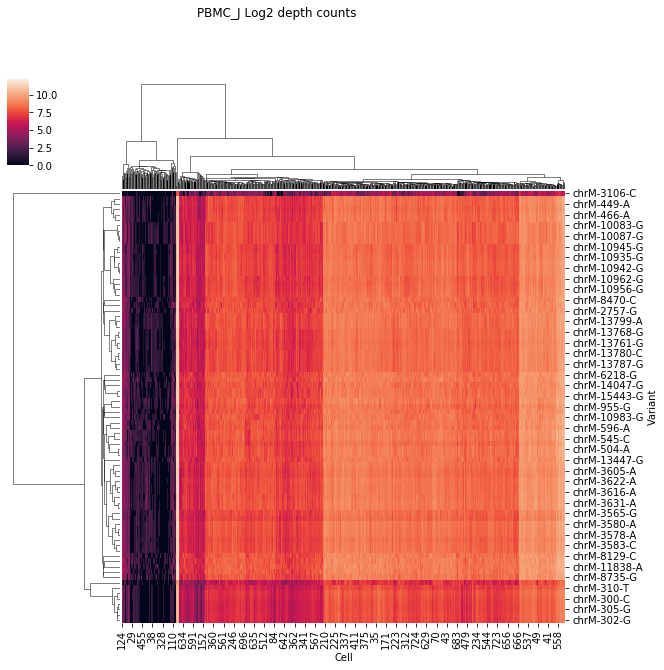

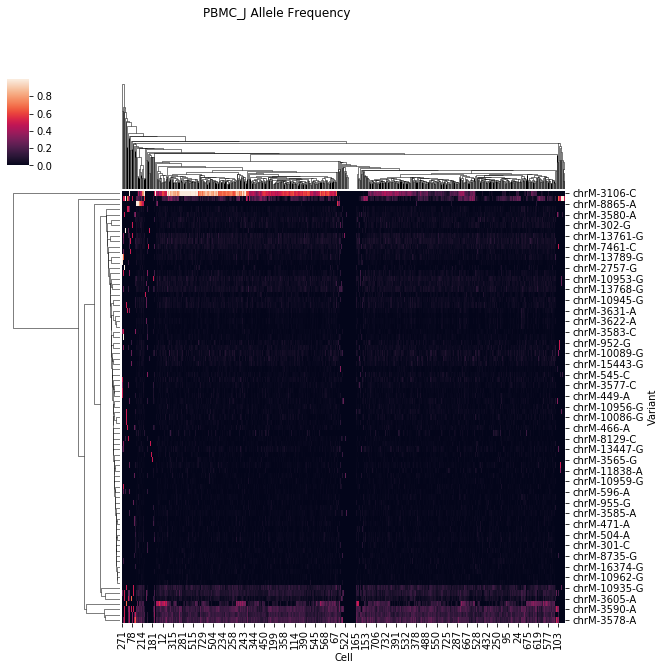

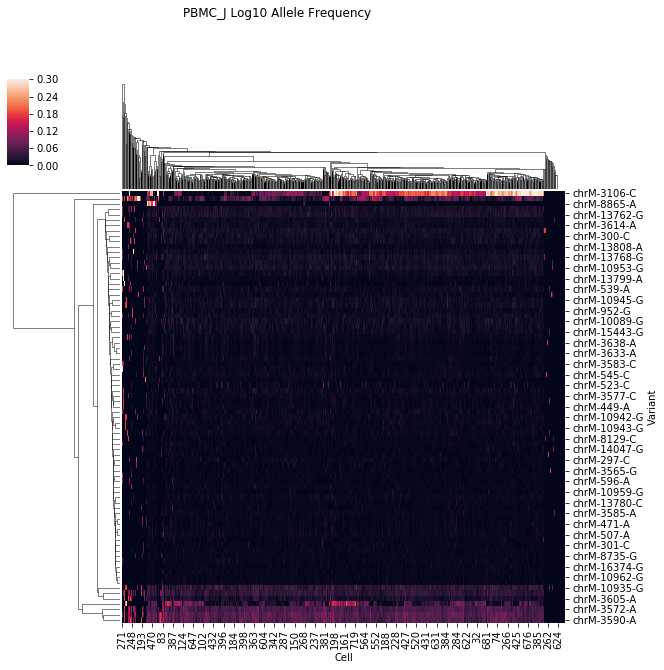

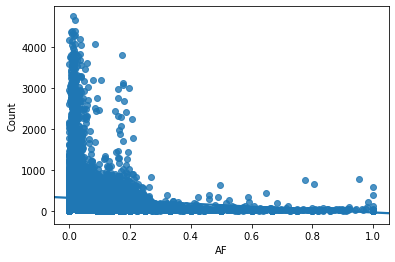

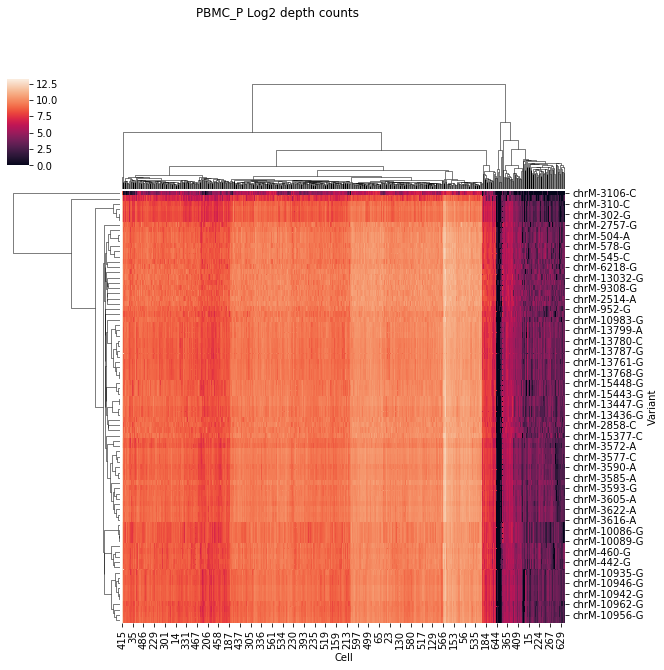

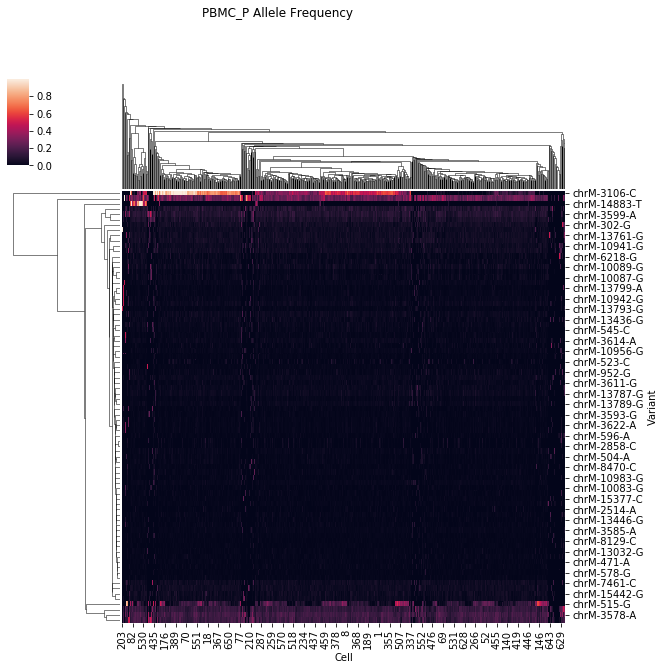

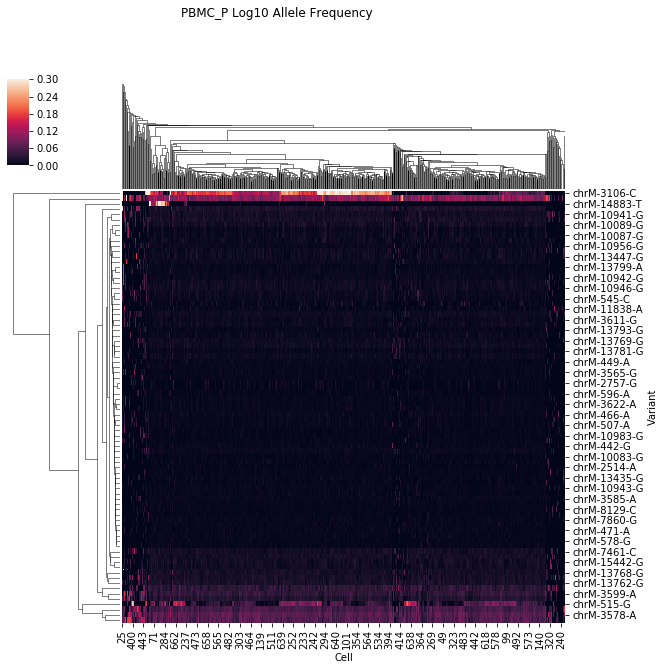

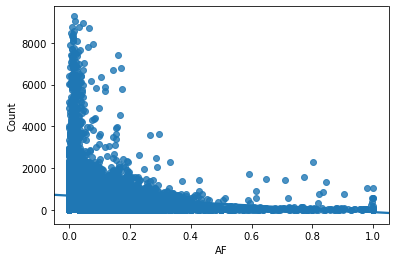

In [12]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]


minAF = 0.01
minCount = 200
curr_val = mt_counts[(mt_counts["minAF"] == minAF) & (minCount == mt_counts["minCount"])]

for ind, val in curr_val.iterrows():
    g = sns.clustermap(np.log2(1+all_dp[ind]))
    plt.suptitle(f"{val['sample']} Log2 depth counts")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    curr_af = all_ad[ind]/(all_dp[ind]+0.0002)

    g = sns.clustermap(curr_af)
    plt.suptitle(f"{val['sample']} Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")


    g = sns.clustermap(np.log10(curr_af+1))
    plt.suptitle(f"{val['sample']} Log10 Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    
    # Correlate AF and depth
    curr_af_melt = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])
    curr_dp_melt = all_dp[ind].melt(value_name='Count', value_vars=all_dp[ind].columns).pipe(drop_zero_count)
    
    #pd.merge(curr_af_melt, curr_dp_melt, left_index=True, right_index=True, how="inner")
    f = plt.figure()
    sns.regplot(x="AF", y="Count", data=pd.merge(curr_af_melt, 
                                                 curr_dp_melt, left_index=True, right_index=True, how="inner"))


In [123]:
#from glasbey import Glasbey
# def plot_domain(names, curr_ax=None, name=None, to_transpose=False):
#     gb = Glasbey()
#     curr_domain_names = curr_domains["Pfam Name"].unique()
#     p = gb.generate_palette(size=len(curr_domain_names) + 1)
#     # Needed for Float problems
#     p[p > 1] = 1
#     p[p < 0] = 0
#     # print(p)
#     # domain_plot.loc[:,:] = [0,0,0]
    
#     color_map = {dom: p[ind + 1] for ind, dom in
#                  enumerate(curr_domains["Pfam Name"].unique())}
#     pfam_map = {val: ind for ind, val in enumerate(curr_domain_names)}

#     if max(curr_domains["Pfam end"].astype(int)) is None:
#         print("Pfam end not there")
#         return

#     domain_plot_1 = np.zeros([max(curr_domains["Pfam end"].astype(int)),
#                               len(curr_domain_names), 3])
#     for i in range(domain_plot_1.shape[0]):
#         for j in range(domain_plot_1.shape[1]):
#             domain_plot_1[i, j, :] = p[0]

#     for ind, val in curr_domains.iterrows():
#         for i in range(val["Pfam start"] - 1, val["Pfam end"]):
#             domain_plot_1[i, pfam_map[val["Pfam Name"]], :] = color_map[
#                 val[
#                     "Pfam Name"]]  # domain_plot.loc[range(val["Pfam start"], val["Pfam end"]+1), val["Pfam ID"]] = color_map[val["Pfam ID"]]

#     if curr_ax is not None:
#         if to_transpose:
#             curr_ax.imshow(np.transpose(domain_plot_1, axes=[1, 0, 2]),
#                            aspect='auto')
#         else:
#             curr_ax.imshow(domain_plot_1,aspect='auto')
#         # curr_ax.imshow(domain_plot_1,aspect='auto')#,cmap='BuPu')

#         # plt.axis('tight')
#        # curr_ax.set_xticks([])
#        # curr_ax.set_yticks([])  # plt.legend(pfam_map.keys())

#     markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o',
#                           linestyle='') for color in color_map.values()]
#     markers.append(plt.Line2D([0, 0], [0, 0], color=p[0], marker='o',
#                               linestyle=''))
#     curr_ax.legend(markers, list(color_map.keys()) + ["None"],
#                    numpoints=1, loc='upper right')

#     return


def plot_heatmap_with_barplot_marginal(df, marginal_x=None, marginal_y=None):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]
    rect_color = [left + width + spacing, bottom + height + spacing,
                  0.15, 0.15]
    # start with a square Figure
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_axes(rect_scatter)
    ax_cbar = fig.add_axes(rect_color)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)


    ax = sns.heatmap(df, ax=ax, cbar_ax=ax_cbar,xticklabels='auto',yticklabels='auto')

    if marginal_x is not None:
        marginal_x.plot.bar(rot=90, ax=ax_histx)
        ax_histx.set_xticklabels([])
    if marginal_y is not None:
        marginal_y.plot.barh(rot=90, ax=ax_histy)
        ax_histy.set_yticklabels([])
    #plot_domain(domains_2, name=None, curr_ax=ax_histx, to_transpose=True)
    #plot_domain(domains_1, name=None, curr_ax=ax_histy,to_transpose=False)
    #helper_save(f_save_fig,to_svg=False)
    return

## Merge PBMC J and P variants

In [112]:
# Change the indices of the cells
merged_af = pd.DataFrame(index=all_dp[0].index)
merged_dp = pd.DataFrame(index=all_dp[0].index)
sample_color_map = {"PBMC_J": "Blue", "PBMC_P": "Red"}
cell_color_map = {}
vars_intersection = {}
for ind, val in curr_val.iterrows():
    curr_af = all_ad[ind]/(all_dp[ind]+0.0002).copy()
    curr_dp = all_dp[ind].copy()
    vars_intersection[ind] = set(curr_dp.index)
    curr_dp.columns = map(lambda x: val['sample']+"_"+str(x), curr_dp.columns.values)
    curr_af.columns = map(lambda x: val['sample']+"_"+str(x), curr_af.columns.values)
    merged_af = pd.merge(merged_af, curr_af, left_index=True, right_index=True, how='outer')
    merged_dp = pd.merge(merged_dp, curr_dp, left_index=True, right_index=True, how='outer')
    for i in curr_dp.columns:
        cell_color_map[i] = sample_color_map[val['sample']]
merged_af = merged_af.fillna(0)
merged_dp = merged_dp.fillna(0)

In [104]:
merged_dp.sum(axis=1)

#CHROM  POS    ALT
chrM    297    C      131616.0
        300    C      422229.0
        301    C      116676.0
        302    G      379166.0
        303    G      267384.0
                        ...   
        15377  C      796995.0
        15442  G      697847.0
        15443  G      730051.0
        15448  G      453845.0
        16374  G      224555.0
Length: 95, dtype: float64

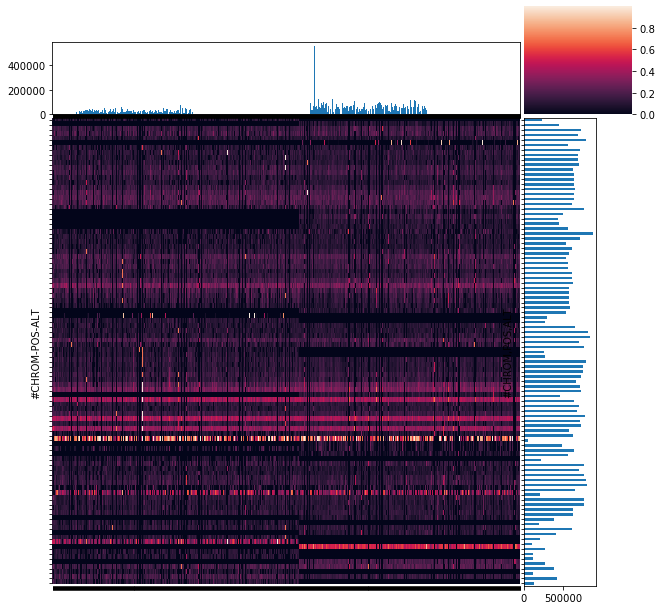

In [124]:
plot_heatmap_with_barplot_marginal(np.sqrt(merged_af.fillna(0)), 
                                   marginal_x=merged_dp.sum(axis=0), 
                                   marginal_y=merged_dp.sum(axis=1))


#merged_dp.sum(axis=1)

In [143]:
g.ax_heatmap.get_position().bounds

(0.28410596026490065,
 0.12499999999999989,
 0.6158940397350993,
 0.5709559257946356)

In [152]:
g.ax_heatmap.get_position()

Bbox([[0.28410596026490065, 0.12499999999999989], [0.8999999999999999, 0.6959559257946355]])

In [148]:
g.ax_col_dendrogram.get_position().bounds

0.28410596026490065

[]

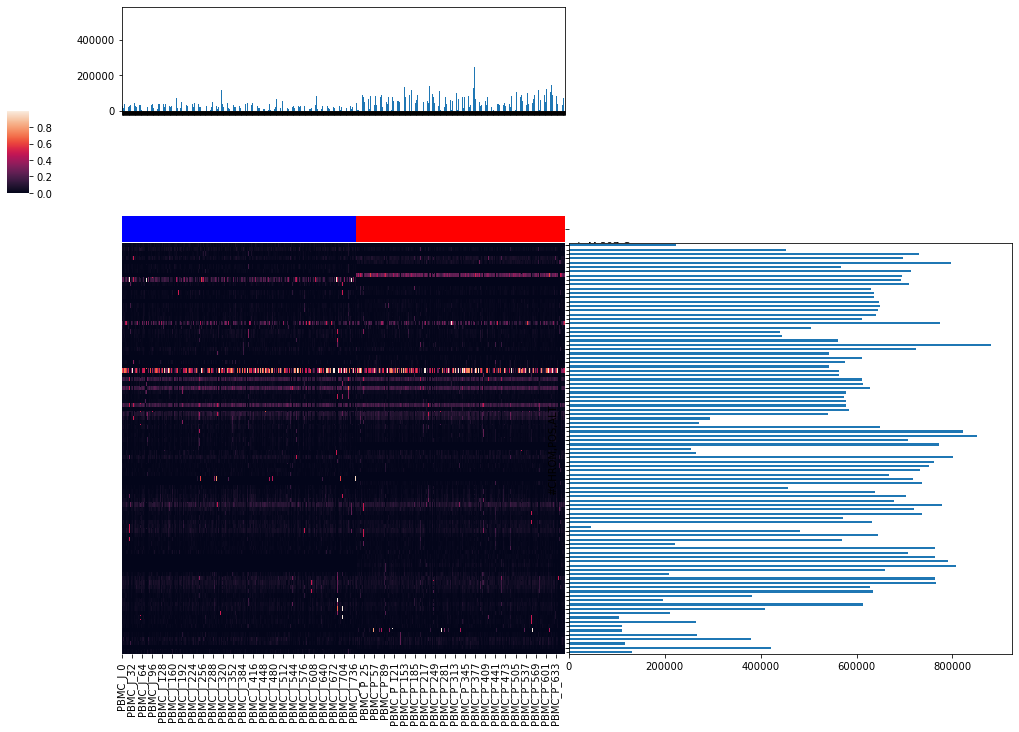

In [167]:
g = sns.clustermap(merged_af.fillna(0), col_cluster=False, row_cluster=False, col_colors=pd.Series(cell_color_map))
fig = g.fig

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
#spacing = 0.0005

# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.1]
# rect_histy = [left + width + spacing, bottom, 0.1, height]
# rect_color = [left + width + spacing, bottom + height + spacing,
#               0.15, 0.15]

rect_histx = [g.ax_heatmap.get_position().bounds[0],
              g.ax_col_dendrogram.get_position().bounds[1]+g.ax_col_dendrogram.get_position().bounds[3]+0, 
              g.ax_heatmap.get_position().bounds[2], 
              g.ax_col_dendrogram.get_position().bounds[3]]
#ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)

merged_dp.sum(axis=0).plot.bar(rot=90, ax=ax_histx)
ax_histx.set_xticklabels([])


rect_histy = [g.ax_heatmap.get_position().bounds[0]+g.ax_heatmap.get_position().bounds[2]+spacing,
              g.ax_heatmap.get_position().bounds[1], 
              rect_histx[2],
              g.ax_heatmap.get_position().bounds[3]]
ax_histy = fig.add_axes(rect_histy)
merged_dp.sum(axis=1).plot.barh(rot=90, ax=ax_histy)
ax_histy.set_yticklabels([])

#ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)


In [100]:
from src.external.pyvenn import venn

Text(0, 0.5, 'Overlapping Variants')

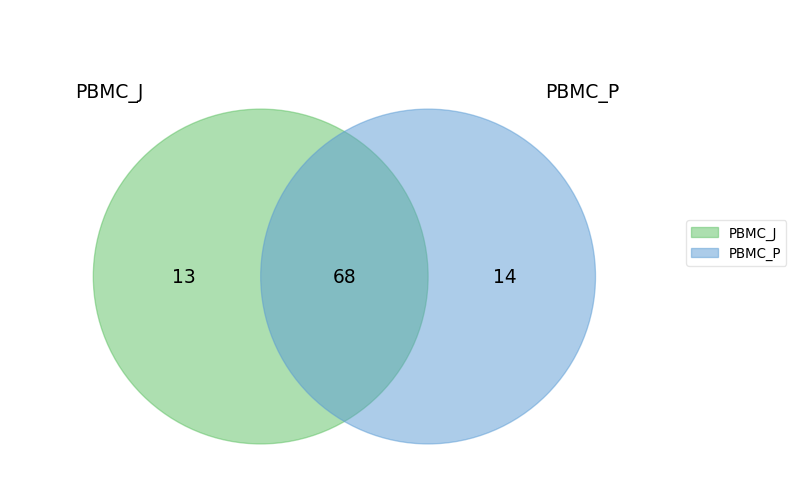

In [44]:
%matplotlib inline
labels = venn.get_labels(list(vars_intersection.values()))
venn.venn2(labels, names=list(map(lambda x: mt_counts.loc[x, "sample"], list(vars_intersection.keys()))))
plt.ylabel("Overlapping Variants")

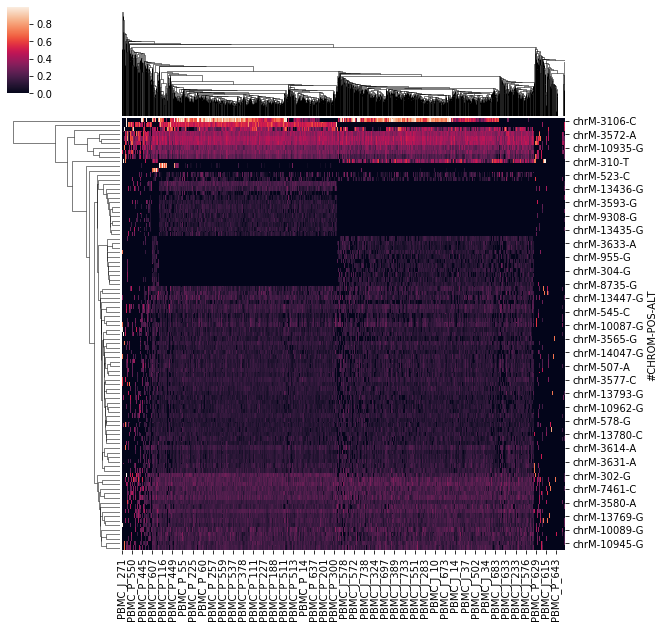

In [125]:
sns.clustermap(np.sqrt(merged_af))

In [45]:
len(set(vars_intersection[4]).intersection(set(vars_intersection[10])))

68

In [51]:
cell_color_map

{'PBMC_J_0': 'Blue',
 'PBMC_J_1': 'Blue',
 'PBMC_J_2': 'Blue',
 'PBMC_J_3': 'Blue',
 'PBMC_J_4': 'Blue',
 'PBMC_J_5': 'Blue',
 'PBMC_J_6': 'Blue',
 'PBMC_J_7': 'Blue',
 'PBMC_J_8': 'Blue',
 'PBMC_J_9': 'Blue',
 'PBMC_J_10': 'Blue',
 'PBMC_J_11': 'Blue',
 'PBMC_J_12': 'Blue',
 'PBMC_J_13': 'Blue',
 'PBMC_J_14': 'Blue',
 'PBMC_J_15': 'Blue',
 'PBMC_J_16': 'Blue',
 'PBMC_J_17': 'Blue',
 'PBMC_J_18': 'Blue',
 'PBMC_J_19': 'Blue',
 'PBMC_J_20': 'Blue',
 'PBMC_J_21': 'Blue',
 'PBMC_J_22': 'Blue',
 'PBMC_J_23': 'Blue',
 'PBMC_J_24': 'Blue',
 'PBMC_J_25': 'Blue',
 'PBMC_J_26': 'Blue',
 'PBMC_J_27': 'Blue',
 'PBMC_J_28': 'Blue',
 'PBMC_J_29': 'Blue',
 'PBMC_J_30': 'Blue',
 'PBMC_J_31': 'Blue',
 'PBMC_J_32': 'Blue',
 'PBMC_J_33': 'Blue',
 'PBMC_J_34': 'Blue',
 'PBMC_J_35': 'Blue',
 'PBMC_J_36': 'Blue',
 'PBMC_J_37': 'Blue',
 'PBMC_J_38': 'Blue',
 'PBMC_J_39': 'Blue',
 'PBMC_J_40': 'Blue',
 'PBMC_J_41': 'Blue',
 'PBMC_J_42': 'Blue',
 'PBMC_J_43': 'Blue',
 'PBMC_J_44': 'Blue',
 'PBMC_J_45': 'Blue'

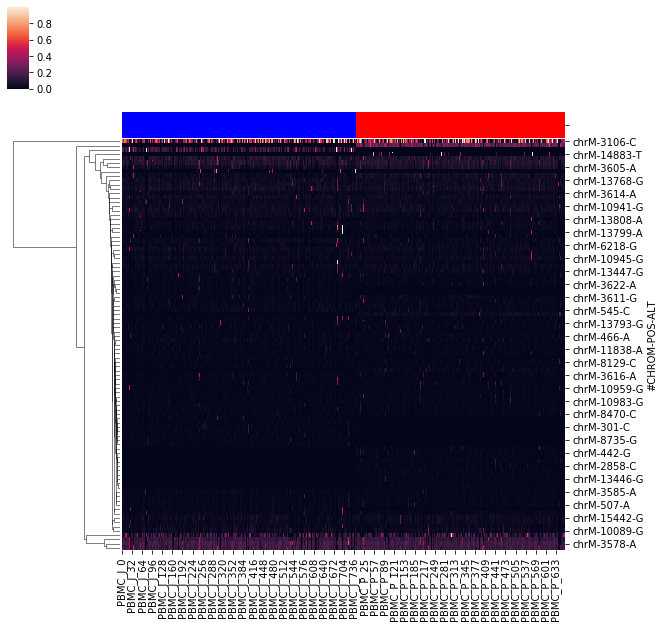

In [53]:
sns.clustermap(merged_af.fillna(0), col_cluster=False, col_colors=pd.Series(cell_color_map))

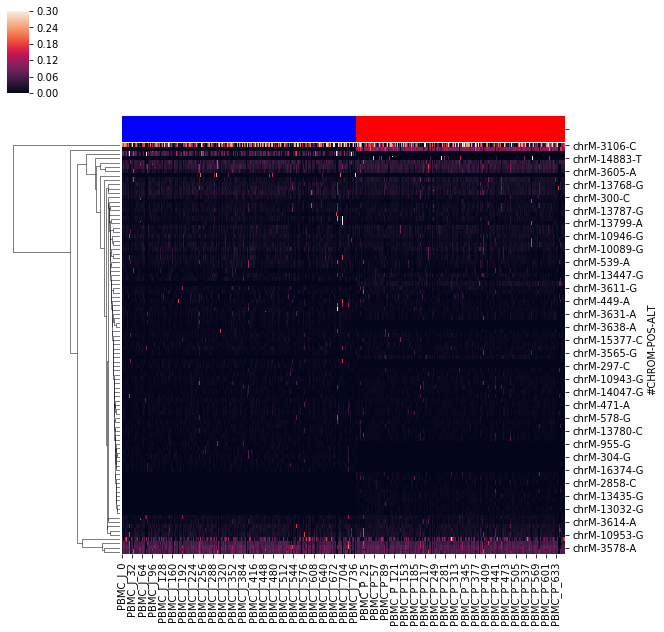

In [59]:
sns.clustermap(np.log10(1+merged_af.fillna(0)), col_cluster=False, col_colors=pd.Series(cell_color_map))

In [67]:
(merged_af == 0).all(axis=0).sum()

0

In [68]:
(merged_af == 0).all(axis=1).sum()

0

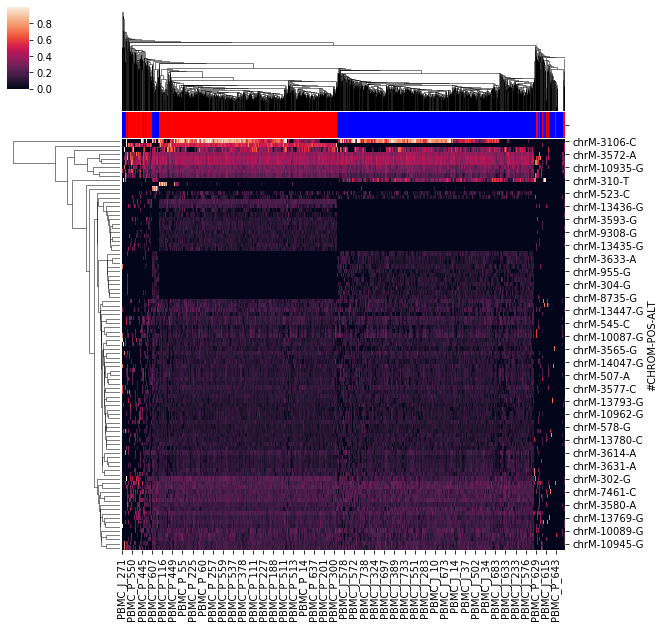

In [71]:
sns.clustermap(np.sqrt(merged_af.fillna(0)), col_cluster=True,
               col_colors=pd.Series(cell_color_map))

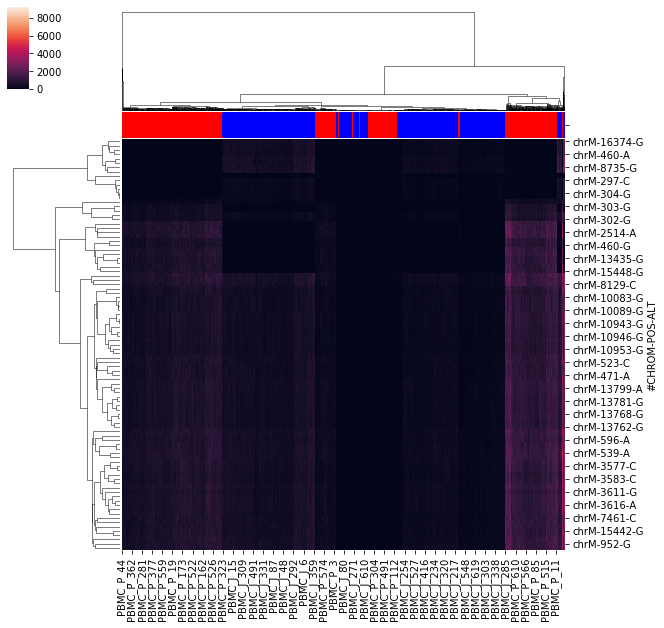

In [57]:
sns.clustermap(merged_dp.fillna(0), col_cluster=True, col_colors=pd.Series(cell_color_map))

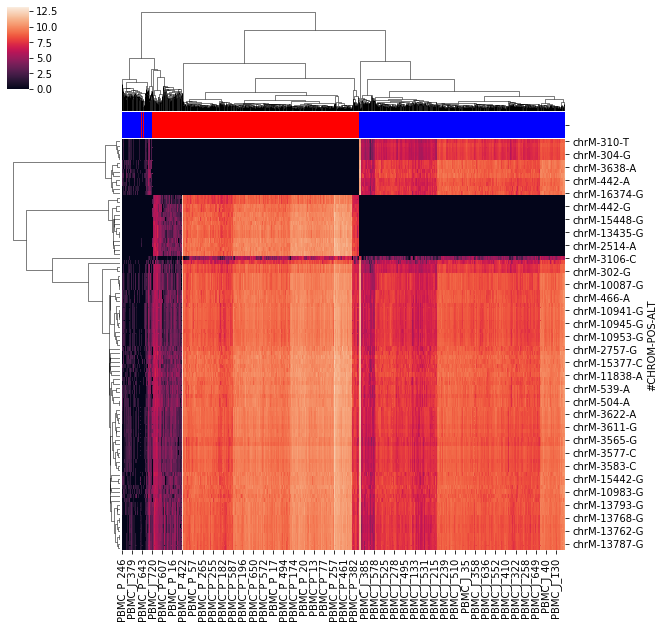

In [56]:
sns.clustermap(np.log2(1+merged_dp.fillna(0)), col_cluster=True, col_colors=pd.Series(cell_color_map))

### Correlate low peak counts with MT expression

In [13]:
sample = val["sample"]
peak_dir = join(config['indir'], sample, "outs", "filtered_peak_bc_matrix")
peaks = load_mtx_df_full((join(peak_dir, "matrix.mtx")), vcf_f=None)
peaks.index.name = "Peak"
peak_barcodes = pd.read_csv(join(peak_dir, "barcodes.tsv"), header=None)[0].values


## The peak ID and the pileup cell barcodes have the same order, seen here:

In [15]:
(peak_barcodes == all_barcodes[ind]).all()

True

In [31]:
cell_dp_counts = all_dp[ind].sum()
cell_peak_counts = peaks.sum()
cell_dp_peak_df = pd.concat((cell_dp_counts, cell_peak_counts), axis=1)
cell_dp_peak_df.columns=["MT Depth", "Peak Counts"]
cell_dp_peak_df

,MT Depth,Peak Counts
0,49563,21099
1,42857,7540
2,2754,636
3,25060,422
4,1195,349
...,...,...
658,30274,5521
659,47517,6568
660,68432,20774
661,71842,5374


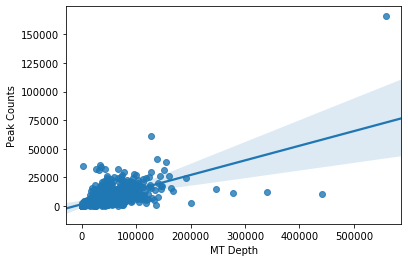

In [32]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=cell_dp_peak_df)

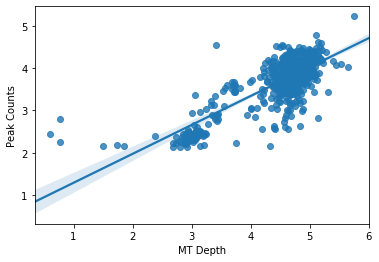

In [34]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=np.log10(cell_dp_peak_df))

### For each MT minCount-minAF create headmap separately for both samples

ind
    sample  minCount  minAF
0   PBMC_J        10   0.01
2   PBMC_J        10   0.01
9   PBMC_P        10   0.01
11  PBMC_P        10   0.01
sample PBMC_J
gridspec indices:
0 0
sample PBMC_J
gridspec indices:
0 0
sample PBMC_P
gridspec indices:
0 1


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


sample PBMC_P
gridspec indices:
0 1
ind
    sample  minCount  minAF
3   PBMC_J        20   0.01
5   PBMC_J        20   0.01
12  PBMC_P        20   0.01
14  PBMC_P        20   0.01
sample PBMC_J
gridspec indices:
0 2
sample PBMC_J
gridspec indices:
0 2
sample PBMC_P
gridspec indices:
0 3
sample PBMC_P
gridspec indices:
0 3
ind
    sample  minCount  minAF
6   PBMC_J       200   0.01
8   PBMC_J       200   0.01
15  PBMC_P       200   0.01
17  PBMC_P       200   0.01
sample PBMC_J
gridspec indices:
0 4
sample PBMC_J
gridspec indices:
0 4
sample PBMC_P
gridspec indices:
0 5
sample PBMC_P
gridspec indices:
0 5
ind
    sample  minCount  minAF
1   PBMC_J        10    0.1
10  PBMC_P        10    0.1
sample PBMC_J
gridspec indices:
1 0
sample PBMC_P
gridspec indices:
1 1
ind
    sample  minCount  minAF
4   PBMC_J        20    0.1
13  PBMC_P        20    0.1
sample PBMC_J
gridspec indices:
1 2
sample PBMC_P
gridspec indices:
1 3
ind
    sample  minCount  minAF
7   PBMC_J       200    0.1
16  PBMC

Text(0.5, 0.98, 'Allele Frequency in MT variants called with Vireo')

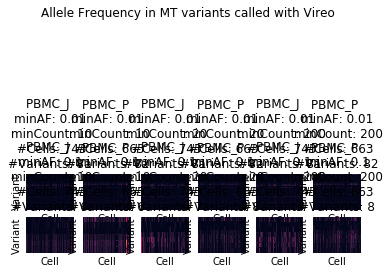

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

#fig = plt.figure(figsize=(10,20))
fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_ad[val2["index"]], ax=curr_ax,xticklabels=False, 
                    yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_ad[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
plt.subplots_adjust(top=0.4)
plt.suptitle("Allele Frequency in MT variants called with Vireo",)
# f3_ax1 = fig3.add_subplot(gs[0, :])
# f3_ax1.set_title('gs[0, :]')
# f3_ax2 = fig3.add_subplot(gs[1, :-1])
# f3_ax2.set_title('gs[1, :-1]')
# f3_ax3 = fig3.add_subplot(gs[1:, -1])
# f3_ax3.set_title('gs[1:, -1]')
# f3_ax4 = fig3.add_subplot(gs[-1, 0])
# f3_ax4.set_title('gs[-1, 0]')
# f3_ax5 = fig3.add_subplot(gs[-1, -2])
# f3_ax5.set_title('gs[-1, -2]')

ind
    sample  minCount  minAF
0   PBMC_J        10   0.01
2   PBMC_J        10   0.01
9   PBMC_P        10   0.01
11  PBMC_P        10   0.01
sample PBMC_J
gridspec indices:
0 0
sample PBMC_J
gridspec indices:
0 0
sample PBMC_P
gridspec indices:
0 1


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


sample PBMC_P
gridspec indices:
0 1
ind
    sample  minCount  minAF
3   PBMC_J        20   0.01
5   PBMC_J        20   0.01
12  PBMC_P        20   0.01
14  PBMC_P        20   0.01
sample PBMC_J
gridspec indices:
0 2
sample PBMC_J
gridspec indices:
0 2
sample PBMC_P
gridspec indices:
0 3
sample PBMC_P
gridspec indices:
0 3
ind
    sample  minCount  minAF
6   PBMC_J       200   0.01
8   PBMC_J       200   0.01
15  PBMC_P       200   0.01
17  PBMC_P       200   0.01
sample PBMC_J
gridspec indices:
0 4
sample PBMC_J
gridspec indices:
0 4
sample PBMC_P
gridspec indices:
0 5
sample PBMC_P
gridspec indices:
0 5
ind
    sample  minCount  minAF
1   PBMC_J        10    0.1
10  PBMC_P        10    0.1
sample PBMC_J
gridspec indices:
1 0
sample PBMC_P
gridspec indices:
1 1
ind
    sample  minCount  minAF
4   PBMC_J        20    0.1
13  PBMC_P        20    0.1
sample PBMC_J
gridspec indices:
1 2
sample PBMC_P
gridspec indices:
1 3
ind
    sample  minCount  minAF
7   PBMC_J       200    0.1
16  PBMC

Text(0.5, 0.98, 'Counts in MT variants called with Vireo')

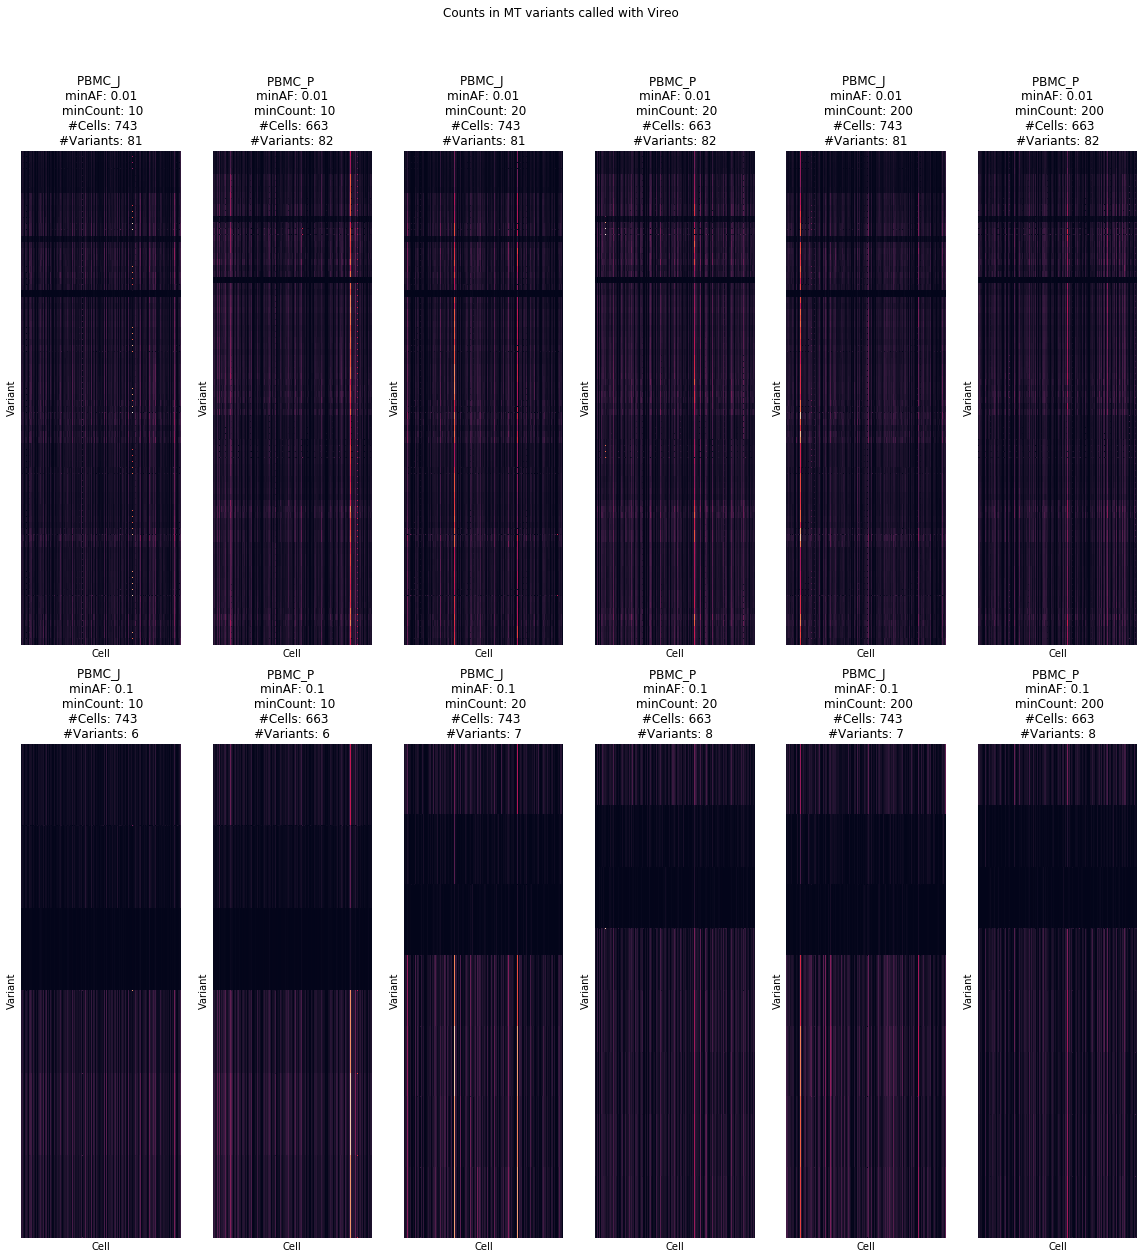

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

fig = plt.figure(figsize=(20,20))
#fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_dp[val2["index"]], ax=curr_ax,xticklabels=False, yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_dp[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
#plt.subplots_adjust(top=0.6)

plt.suptitle("Counts in MT variants called with Vireo")

Text(0.5, 1, 'Log2 allele variant counts')

<Figure size 720x720 with 0 Axes>

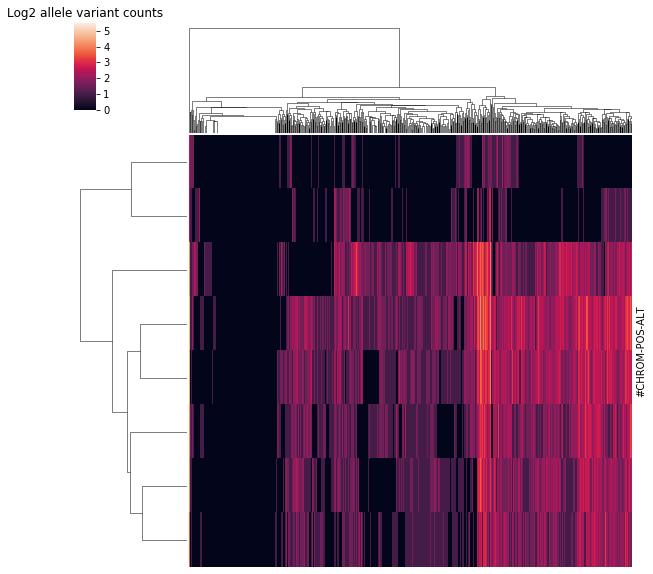

In [15]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_ad[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 allele variant counts")

Text(0.5, 1, 'Log2 depth counts')

<Figure size 720x720 with 0 Axes>

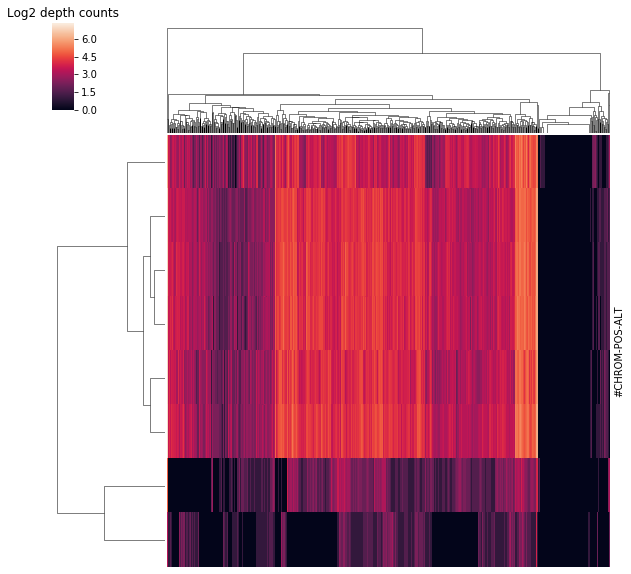

In [100]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_dp[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 depth counts")

Text(0.5, 1, 'Allele Frequency')

<Figure size 720x720 with 0 Axes>

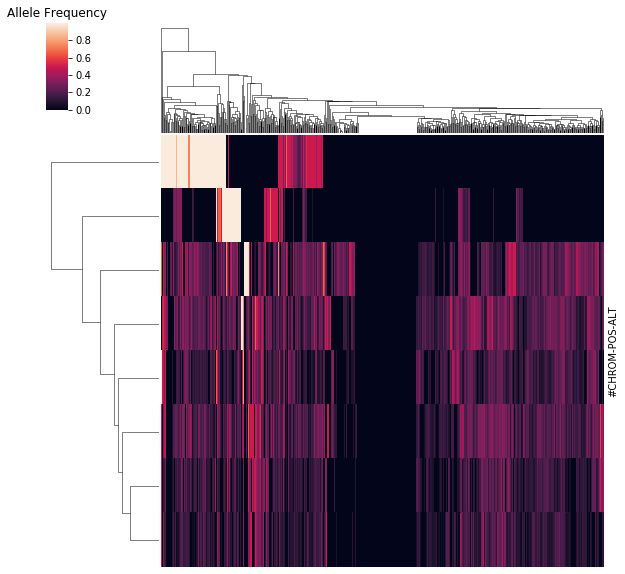

In [104]:
f = plt.figure(figsize=(10,10))
sns.clustermap(all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002), xticklabels=False, yticklabels=False)
plt.title("Allele Frequency")

In [128]:
curr_af.reset_index()

,#CHROM,POS,ALT,0,1,2,3,4,5,6,...,653,654,655,656,657,658,659,660,661,662
0,chrM,310,C,0.333322,0.399984,0.0,0.000000,0.0,0.277775,0.333322,...,0.249998,0.142853,0.238093,0.000000,0.299994,0.000000,0.235291,0.333326,0.133332,0.000000
1,chrM,515,G,0.000000,0.000000,0.0,0.000000,0.0,0.999800,0.999800,...,0.399984,0.000000,0.000000,0.249988,0.000000,0.000000,0.499950,0.000000,0.000000,0.999933
2,chrM,3106,A,0.999800,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499950,0.000000,0.000000
3,chrM,3572,A,0.307688,0.083332,0.0,0.272722,0.0,0.166661,0.000000,...,0.142855,0.181815,0.111110,0.124997,0.294114,0.000000,0.166661,0.050000,0.124998,0.124997
4,chrM,3578,A,0.437495,0.230766,0.0,0.363630,0.0,0.249994,0.333322,...,0.142855,0.333326,0.099999,0.222217,0.294114,0.000000,0.166661,0.249998,0.312496,0.230766
5,chrM,3590,A,0.444435,0.000000,0.0,0.249996,0.0,0.111109,0.142853,...,0.214283,0.222217,0.199996,0.199992,0.238093,0.166661,0.399984,0.190474,0.230766,0.249994
6,chrM,3599,A,0.153844,0.000000,0.0,0.000000,0.0,0.222217,0.124997,...,0.062499,0.124997,0.099998,0.285706,0.199998,0.000000,0.199992,0.142856,0.214283,0.124997
7,chrM,3605,A,0.153844,0.000000,0.0,0.124997,0.0,0.199996,0.124997,...,0.062499,0.142853,0.062499,0.000000,0.192306,0.000000,0.000000,0.142856,0.090907,0.124997


In [130]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]
curr_af = all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002)
curr_af = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])

curr_dp = all_dp[val2["index"]].melt(value_name='Count', value_vars=all_dp[val2["index"]].columns).pipe(drop_zero_count)
curr_dp

,variable,Count
0,0,6
2,0,1
3,0,13
4,0,16
5,0,9
...,...,...
5299,662,8
5300,662,13
5301,662,8
5302,662,8


In [131]:
curr_af

,#CHROM,POS,ALT,variable,AF
0,chrM,310,C,0,0.333322
1,chrM,515,G,0,0.000000
2,chrM,3106,A,0,0.999800
3,chrM,3572,A,0,0.307688
4,chrM,3578,A,0,0.437495
...,...,...,...,...,...
5299,chrM,3572,A,662,0.124997
5300,chrM,3578,A,662,0.230766
5301,chrM,3590,A,662,0.249994
5302,chrM,3599,A,662,0.124997


In [123]:
pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner")

sns.regplot(x="AF", y="Count", data=pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner"))

,variable_x,AF,variable_y,Count
0,0,0.333322,0,6
2,0,0.999800,0,1
3,0,0.307688,0,13
4,0,0.437495,0,16
5,0,0.444435,0,9
...,...,...,...,...
5299,662,0.124997,662,8
5300,662,0.230766,662,13
5301,662,0.249994,662,8
5302,662,0.124997,662,8


### Variants

In [9]:
variant_counts = pd.DataFrame(product(config["samples"], config["pre_variant"]["minCOUNT"], 
                                      config["pre_variant"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in variant_counts.iterrows():
    curr_dir = f"data/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf = load_pileup(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
variant_counts

data/PBMC_J_cellSNP_minC20_minAF0.2/
data/PBMC_J_cellSNP_minC20_minAF0.4/
data/PBMC_J_cellSNP_minC200_minAF0.2/
data/PBMC_J_cellSNP_minC200_minAF0.4/
data/PBMC_P_cellSNP_minC20_minAF0.2/
data/PBMC_P_cellSNP_minC20_minAF0.4/
data/PBMC_P_cellSNP_minC200_minAF0.2/
data/PBMC_P_cellSNP_minC200_minAF0.4/


,sample,minCount,minAF
0,PBMC_J,20,0.2
1,PBMC_J,20,0.4
2,PBMC_J,200,0.2
3,PBMC_J,200,0.4
4,PBMC_P,20,0.2
5,PBMC_P,20,0.4
6,PBMC_P,200,0.2
7,PBMC_P,200,0.4


### Load and process input data

In [12]:
for ind, val in mt_counts.iterrows():
    print(ind)
    DP_df = pd.DataFrame(DP.todense())
    DP_df.index.name = "Variant"
    DP_df.columns.name = "Cell"
    AD_df.index.name = "Variant"
    AD_df.columns.name = "Cell"

    print("AD shape", AD_df.shape)
    print("DP shape", DP_df.shape)
    AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    AD_df

0
1
2
3


In [12]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
vcf = pd.read_csv(VCF_F, sep='\t', skiprows=1)
AD_df = pd.DataFrame(AD.todense())
DP_df = pd.DataFrame(DP.todense())
DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AD_df.index.name = "Variant"
AD_df.columns.name = "Cell"

print("AD shape", AD_df.shape)
print("DP shape", DP_df.shape)
AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
AD_df

AD shape (149, 743)
DP shape (149, 743)


0    1    2    3    4    5    6    7    8    9    ...  \
#CHROM POS       ALT                                                    ...   
chr1   109656105 T      0    0    0    0    0    0    0    0    0    0  ...   
       167617624 G      0    0    0    0    0    0    0    0    0    0  ...   
       171435012 C      0    0    0    0    0    0    0    0    0    0  ...   
       202952912 A      0    0    0    0    0    0    0    0    0    0  ...   
       234866206 G      0    0    0    0    0    0    0    0    0    0  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
chr19  18291797  T      0    0    0    0    0    0    0    0    0    0  ...   
chr20  57130942  A      0    0    0    0    0    0    0    0    0    0  ...   
chr21  36430255  C      0    0    0    0    0    0    0    0    0    0  ...   
chr22  29553942  G      0    0    0    0    0    0    0    0    0    0  ...   
       31792665  T      0    0    0    0    0    0    0    0    0    0  ...   

                      733  734  735  736  737  738  739  740  741  742  
#CHROM POS       ALT                                                    
chr1   109656105 T      0    0    0    0    0    0    0    0    0    0  
       167617624 G      0    0    0    0    0    0    0    0    0    0  
       171435012 C      0    0    0    0    0    0    0    0    0    0  
       202952912 A      0    0    0    0    0    0    0    0    0    0  
       234866206 G      0    0    0    0    0    0    0    0    0    0  
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
chr19  18291797  T      0    0    0    0    0    0    0    0    0    0  
chr20  57130942  A      0    0    0    0    0    0    0    0    0    0  
chr21  36430255  C      0    0    0    0    0    0    0    0    0    0  
chr22  29553942  G      0    0    0    0    0    0    0    0    0    0  
       31792665  T      0    0    0    0    0    0    0    0    0    0  

[149 rows x 743 columns]

## Create Allele Frequency as AD/(DP+0.001) 

Text(183.55629139072846, 0.5, 'Variant')

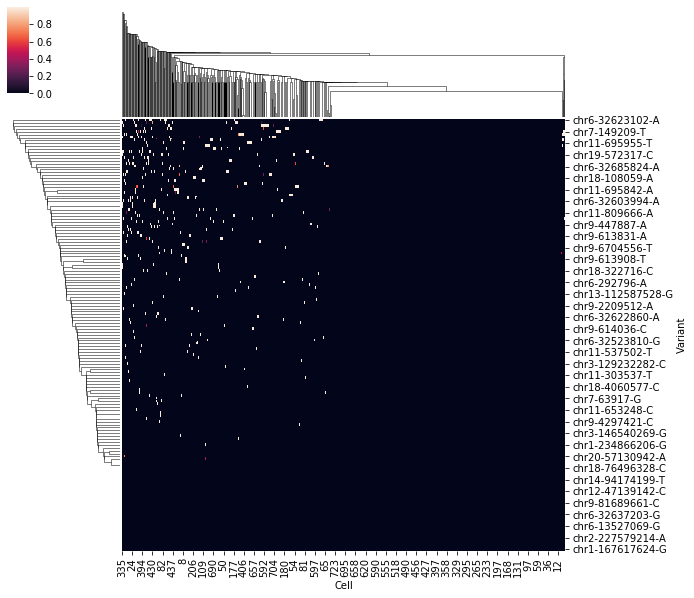

In [13]:
AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(AF_df)
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Log 10

Text(183.55629139072846, 0.5, 'Variant')

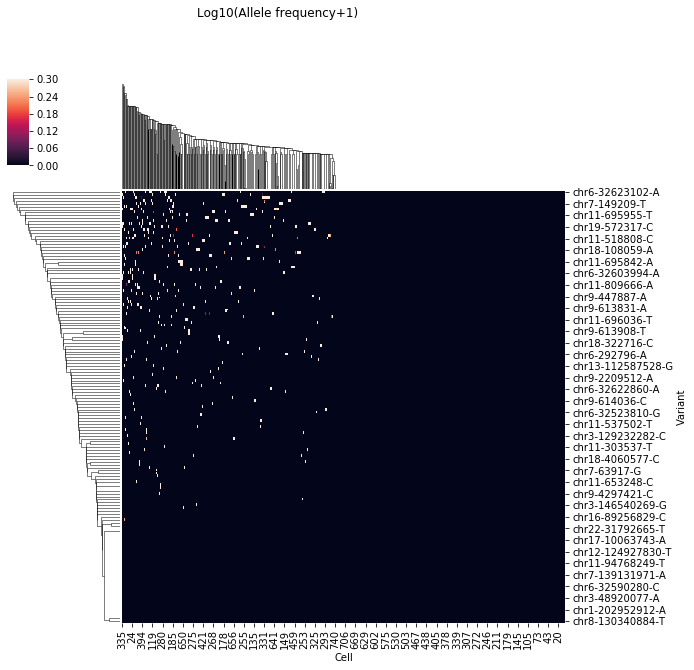

In [14]:
AF_df = AD_df/(DP_df+0.001)

g = sns.clustermap(np.log10(AF_df+1))
g.fig.suptitle("Log10(Allele frequency+1)")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Depth

Text(183.55629139072846, 0.5, 'Variant')

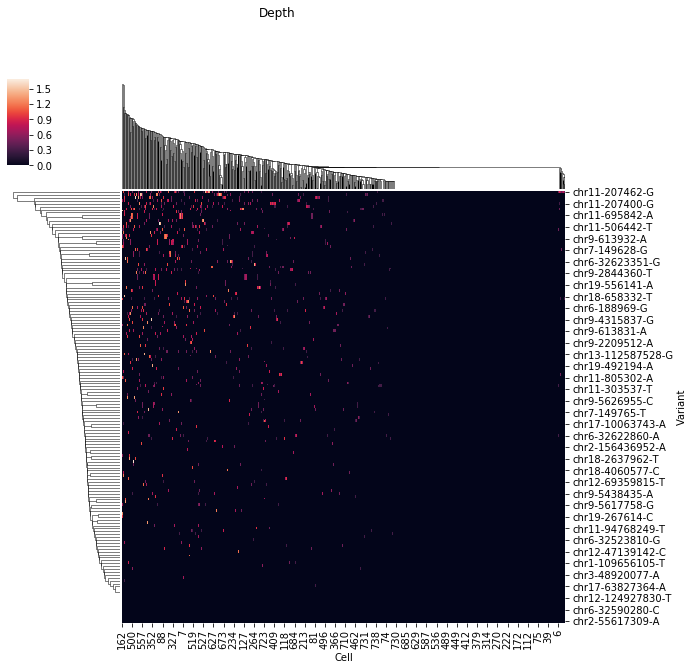

In [15]:
#AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(np.log10(DP_df+1))
g.fig.suptitle("Depth")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

### There shouldnt be cells and variants that are undetected, but we see that below for both Allele Frequencies and read depth

In [32]:
print(f"Number of cells with no variants detected: {(AF_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(AF_df == 0).all(axis=1).sum()}")

Number of cells with no variants detected: 388
Number of variants with no cells having coverage: 31


In [33]:
print(f"Number of cells with no variants detected: {(DP_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(DP_df == 0).all(axis=1).sum()}")

Number of cells with no variants detected: 277
Number of variants with no cells having coverage: 12


## Remove the 0s in both areas

In [34]:
def remove_zeros(df, multi_index=False):
    if multi_index:
        df.index = list(map(lambda x: "_".join(np.array(x)), DP_df.index))
    df = df.loc[~((AF_df==0).all(axis=1)),:]
    df = df.loc[:, ~((AF_df==0).all(axis=0))]
    return df

AF_df_filt = remove_zeros(AF_df)
DP_df_filt = remove_zeros(DP_df)

print("After removing variants and cells with all 0s")
print(f"Number of variants left are {AF_df_filt.shape[0]}")
print(f"Number of cells left are {AF_df_filt.shape[1]}")

After removing variants and cells with all 0s
Number of variants left are 118
Number of cells left are 355


In [36]:
AF_joy

,ID,AF
0,#CHROM,chr1
1,#CHROM,chr1
2,#CHROM,chr2
3,#CHROM,chr2
4,#CHROM,chr3
...,...,...
42239,738,0
42240,738,0
42241,738,0
42242,738,0


In [37]:
AF_df_filt

2    3    4    7    8    10   11        13        15   \
#CHROM POS       ALT                                                          
chr1   171435012 C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
       234866206 G    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
chr2   677213    A    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.999938   
       156436952 A    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
chr3   16513716  C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
...                   ...  ...  ...  ...  ...  ...  ...       ...       ...   
chr19  925713    A    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.999001  0.000000   
       10516256  C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
       18291797  T    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
chr20  57130942  A    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
chr21  36430255  C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   

                           24   ...  725  726  727       729  731  732  734  \
#CHROM POS       ALT            ...                                           
chr1   171435012 C    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
       234866206 G    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
chr2   677213    A    0.000000  ...  0.0  0.0  0.0  0.999001  0.0  0.0  0.0   
       156436952 A    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
chr3   16513716  C    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
...                        ...  ...  ...  ...  ...       ...  ...  ...  ...   
chr19  925713    A    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
       10516256  C    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
       18291797  T    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
chr20  57130942  A    0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
chr21  36430255  C    0.999001  ...  0.0  0.0  0.0  0.999750  0.0  0.0  0.0   

                      735     736  738  
#CHROM POS       ALT                    
chr1   171435012 C    0.0  0.0000  0.0  
       234866206 G    0.0  0.0000  0.0  
chr2   677213    A    0.0  0.0000  0.0  
       156436952 A    0.0  0.0000  0.0  
chr3   16513716  C    0.0  0.9995  0.0  
...                   ...     ...  ...  
chr19  925713    A    0.0  0.0000  0.0  
       10516256  C    0.0  0.0000  0.0  
       18291797  T    0.0  0.0000  0.0  
chr20  57130942  A    0.0  0.0000  0.0  
chr21  36430255  C    0.0  0.0000  0.0  

[118 rows x 355 columns]

In [38]:
AF_df_filt.reset_index()

,#CHROM,POS,ALT,2,3,4,7,8,10,11,...,725,726,727,729,731,732,734,735,736,738
0,chr1,171435012,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
1,chr1,234866206,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
2,chr2,677213,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.999001,0.0,0.0,0.0,0.0,0.0000,0.0
3,chr2,156436952,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
4,chr3,16513716,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.9995,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,chr19,925713,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
114,chr19,10516256,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
115,chr19,18291797,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0
116,chr20,57130942,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0


In [40]:
AF_joy

,#CHROM,POS,ALT,variable,AF,ID
0,chr1,171435012,C,2,0.0,chr1_171435012_C
1,chr1,234866206,G,2,0.0,chr1_234866206_G
2,chr2,677213,A,2,0.0,chr2_677213_A
3,chr2,156436952,A,2,0.0,chr2_156436952_A
4,chr3,16513716,C,2,0.0,chr3_16513716_C
...,...,...,...,...,...,...
41885,chr19,925713,A,738,0.0,chr19_925713_A
41886,chr19,10516256,C,738,0.0,chr19_10516256_C
41887,chr19,18291797,T,738,0.0,chr19_18291797_T
41888,chr20,57130942,A,738,0.0,chr20_57130942_A


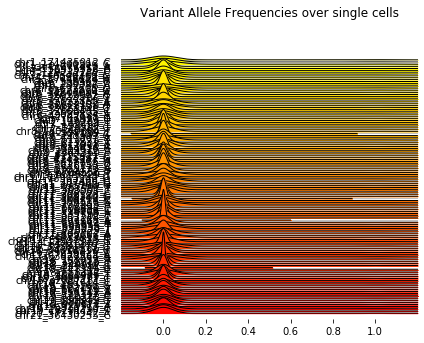

In [47]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
AF_joy.head()
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]
labels = AF_joy["ID"].unique()
fig, axes = joypy.joyplot(AF_joy, by="ID", column="AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)

# fig, axes = joypy.joyplot(temp, by="Year", column="Anomaly", labels=labels, range_style='own', 
#                           grid="y", linewidth=1, legend=False, figsize=(6,5),
#                           title="Global daily temperature 1880-2014 \n(°C above 1950-80 average)",
#                           colormap=cm.autumn_r)

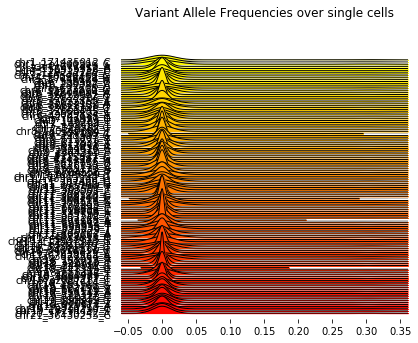

In [48]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
AF_joy.head()
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]
labels = AF_joy["ID"].unique()
AF_joy["log AF"] = np.log10(AF_joy["AF"]+1)
fig, axes = joypy.joyplot(AF_joy, by="ID", column="log AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)

# fig, axes = joypy.joyplot(temp, by="Year", column="Anomaly", labels=labels, range_style='own', 
#                           grid="y", linewidth=1, legend=False, figsize=(6,5),
#                           title="Global daily temperature 1880-2014 \n(°C above 1950-80 average)",
#                           colormap=cm.autumn_r)

In [51]:
AF_joy[AF_joy["AF"]>0]

,#CHROM,POS,ALT,variable,AF,ID,log AF
11,chr6,292796,A,2,0.999001,chr6_292796_A,0.300813
29,chr7,149484,T,2,0.999667,chr7_149484_T,0.300958
172,chr10,78303342,G,3,0.999001,chr10_78303342_G,0.300813
270,chr9,398309,G,4,0.999667,chr9_398309_G,0.300958
430,chr11,695955,T,7,0.999889,chr11_695955_T,0.301006
...,...,...,...,...,...,...,...
41685,chr7,149765,T,736,0.999950,chr7_149765_T,0.301019
41723,chr11,518808,C,736,0.999500,chr11_518808_C,0.300921
41755,chr18,32087181,T,736,0.999500,chr18_32087181_T,0.300921
41765,chr19,680874,T,736,0.999001,chr19_680874_T,0.300813


### Remove all 0s and plot

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/joypy/joyplot.py:281: UserWarning: The data contains a group with a single distinct value (0.9990009990009991) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/joypy/joyplot.py:281: UserWarning: The data contains a group with a single distinct value (0.9995002498750625) having infinite probability density. Consider using a different visualization.
  "Consider using a different visualization.".format(val))


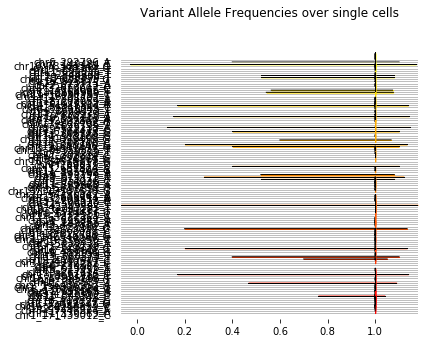

In [52]:
%matplotlib inline
import joypy
#from matplotlib import pyplot as plt

from matplotlib import cm

#AF_joy=AF_df_filt.reset_index().melt(id_vars=["#CHROM","POS","ALT"], value_name="AF")
#AF_joy["ID"] = AF_joy.apply(lambda x: f"{x['#CHROM']}_{str(x['POS'])}_{x['ALT']}", axis=1)
                            
#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]


AF_joy_0 = AF_joy[AF_joy["AF"]>0].copy()
labels = AF_joy_0["ID"].unique()
fig, axes = joypy.joyplot(AF_joy_0, by="ID", column="AF", labels=labels, range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Variant Allele Frequencies over single cells",
                          colormap=cm.autumn_r)


In [169]:
mt_counts

,sample,minCount,minAF
0,PBMC_J,10,0.01
1,PBMC_J,10,0.10
2,PBMC_J,20,0.01
3,PBMC_J,20,0.10
4,PBMC_J,200,0.01
5,PBMC_J,200,0.10
6,PBMC_P,10,0.01
7,PBMC_P,10,0.10
8,PBMC_P,20,0.01
9,PBMC_P,20,0.10


In [175]:
curr_af = (all_ad[4]/(all_dp[ind]+0.0002)).fillna(0)

In [182]:
curr_af.head()

0         1         2         3       4         5    \
#CHROM POS ALT                                                             
chrM   297 C    0.000000  0.000000  0.000000  0.000000     0.0  0.000000   
       300 C    0.042506  0.022013  0.761898  0.012658     0.0  0.005792   
       301 C    0.000000  0.000000  0.000000  0.000000     0.0  0.000000   
       302 G    0.021053  0.013423  0.549995  0.009302  5000.0  0.002217   
       303 G    0.000000  0.000000  0.000000  0.000000     0.0  0.000000   

                     6         7         8         9    ...  733  734  735  \
#CHROM POS ALT                                          ...                  
chrM   297 C    0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0   
       300 C    0.024194  1.333244  0.053476  0.020513  ...  0.0  0.0  0.0   
       301 C    0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0   
       302 G    0.009063  1.999800  0.053892  0.021307  ...  0.0  0.0  0.0   
       303 G    0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0   

                736  737  738  739  740  741  742  
#CHROM POS ALT                                     
chrM   297 C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       300 C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       301 C    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       302 G    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       303 G    0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 743 columns]

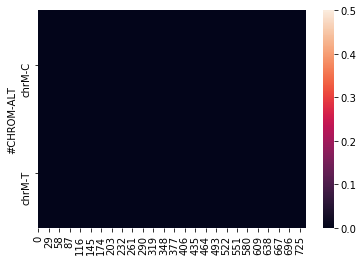

In [185]:
sns.heatmap(curr_af.xs(310, level='POS'), vmin=0, vmax=0.5)

In [179]:
curr_af.index.get_level_values("POS") #["POS"]

Int64Index([  297,   300,   301,   302,   303,   304,   305,   310,   310,
              442,   442,   449,   460,   460,   466,   471,   504,   507,
              515,   523,   539,   545,   578,   596,   952,   955,  2514,
             2757,  2858,  3106,  3565,  3572,  3577,  3578,  3580,  3583,
             3585,  3590,  3593,  3599,  3605,  3611,  3614,  3616,  3622,
             3631,  3633,  3638,  6218,  7461,  7860,  8129,  8470,  8735,
             8865,  9308, 10083, 10086, 10087, 10089, 10935, 10941, 10942,
            10943, 10945, 10946, 10953, 10956, 10959, 10962, 10983, 11838,
            13032, 13435, 13436, 13446, 13447, 13761, 13762, 13768, 13769,
            13780, 13781, 13787, 13789, 13793, 13799, 13808, 14047, 14883,
            15377, 15442, 15443, 15448, 16374],
           dtype='int64', name='POS')